# Instructions

### Step 0
Before starting, we need the following:

* a shapefile containing the training labels for the area of interest
* python 3 installation with the dependencies in step 2

### Step 1
Run the following earth engine script in Google Earth Engine and download the images and tables from Google Drive

In this example we export the data from both year 2014 and 2015. Rename the folders from the first export or change the output folder in the script so they are downloaded into separate folders. It is also necessary to copy the coordinates of the selected area in earth engine and convert it to WKT format. Example:

### Step 2
The scripts for input data processing are placed under scripts/ folder. The lastest scripts used here are read_land_use_no_gdal.py and read_image_data_scaleable.py. Import them to use in a data processing script. They depend on the following modules:
* numpy
* pandas
* rasterio
* shapely
* fiona

In [1]:
import sys
import numpy as np
import pandas as pd
import shelve
import scripts.read_land_use_no_gdal as rlu
import scripts.read_image_data_scaleable as rid

Matplotlib is not necessary and is only for visualisation.

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

### Step 3
Define the area of interest and generate a label map of the area.

In [3]:
polygon = "POLYGON ((143.32317350376297 -37.496296386368165, 143.32180000642074 -37.70330610816869, 143.59543478539388 -37.70317028876007, 143.5968081449812 -37.49575155973978, 143.32317350376297 -37.496296386368165))"

Use read_land_use() to generate a label map and a dict of classes. We will have to fill in the resolution of downloaded images (they should have the same resolution). The x and y here are inverted compared to the matrix representation.

In [4]:
array, classes = rlu.read_land_use(da_shapefile="SDM324649_full/ll_gda94/sde_shape/whole/VIC/CATCHMENTS/layer/landuse_2014.shp",
                  resolution=(1022, 973),  # 1022 in width and 973 in height
                  area_filter=polygon,
                  buffer=-0.001,  # unit?
                  processes=8)

### Step 4
Use old_data_preprocess_workflow() to generate the training set:

In [5]:
rid.old_data_preprocess_workflow(image_dir='area1/2014/images/',
                                         mask_dir='area1/2014/masks/', 
                                         table_dir='area1/2014/tables/LC8_SR.csv', 
                                         new_table_dir='area1/2015/tables/LC8_SR.csv', 
                                         shelve_root_dir='models/area1/shelves/', 
                                         labels=array, 
                                         processes=12, 
                                         max_days_apart=30, 
                                         step=250000,
                                         to_csv=True)

reading data...
reading new timestamps...
interpolating images...
generating sets...


True

### Step 5
Use new_data_preprocess_workflow() to generate the prediction set:

In [8]:
rid.new_data_preprocess_workflow(image_dir='area1/2015/images/',
                                         mask_dir='area1/2015/masks/', 
                                         table_dir='area1/2015/tables/LC8_SR.csv', 
                                         shelve_root_dir='models/area1/shelves/', 
                                         processes=8, 
                                         max_days_apart=30, 
                                         step=250000,
                                         to_csv=True)

reading data...
reading new timestamps...
interpolating images...


Exception ignored in: <bound method Shelf.__del__ of <shelve.DbfilenameShelf object at 0x7f0c0eb06f98>>
Exception ignored in: <bound method Shelf.__del__ of <shelve.DbfilenameShelf object at 0x7f0c0eb06898>>
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.5/shelve.py", line 144, in close
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.5/shelve.py", line 162, in __del__
  File "/home/ubuntu/anaconda3/lib/python3.5/shelve.py", line 162, in __del__
    self.close()
    self.close()
  File "/home/ubuntu/anaconda3/lib/python3.5/shelve.py", line 144, in close
    self.sync()
  File "/home/ubuntu/anaconda3/lib/python3.5/shelve.py", line 172, in sync
    self.sync()
    self.dict.sync()
  File "/home/ubuntu/anaconda3/lib/python3.5/shelve.py", line 172, in sync
  File "/home/ubuntu/anaconda3/lib/python3.5/dbm/dumb.py", line 124, in _commit
    self.dict.sync()
    self._chmod(self._dirfile)
  File "/home/ubuntu/anaconda3/lib/python3.5/

generating sets...


True

### Step 6
To access the training and prediction set after preprocessing, load the corresponding Shelf/csv files:

### Shelf version:

In [9]:
# close the shelves first
train.close()
to_predict.close()

In [10]:
train = shelve.open('models/area1/shelves/trains')
to_predict = shelve.open('models/area1/shelves/to_predict')

Example: reconstructing the whole training set

In [11]:
full_train = pd.concat([s[1] for s in train.values()], axis=0)  # order does not matter here

In [12]:
full_train.shape

(994406, 121)

In [13]:
full_predict = pd.concat([s[1] for s in to_predict.values()], axis=0)

In [14]:
full_predict.shape

(994406, 120)

### CSV version

In [6]:
full_train = pd.read_csv('models/area1/shelves/trains.csv')

In [7]:
full_train.head()

,x,y,1394669354132_0,1394669354132_1,1394669354132_2,1395274523472_0,1395274523472_1,1395274523472_2,1396051746370_0,1396051746370_1,...,1420934982577_0,1420934982577_1,1420934982577_2,1421540154238_0,1421540154238_1,1421540154238_2,1422317382683_0,1422317382683_1,1422317382683_2,label
0,0,0,-9999,-9999,-9999,-9999,-9999,-9999,3683,300,...,2382,1006,739,2382,1006,739,2382,1006,739,2
1,0,1,-9999,-9999,-9999,-9999,-9999,-9999,3683,300,...,2382,1006,739,2382,1006,739,2382,1006,739,2
2,0,2,-9999,-9999,-9999,-9999,-9999,-9999,3438,349,...,2360,983,788,2360,983,788,2360,983,788,0
3,0,3,-9999,-9999,-9999,-9999,-9999,-9999,3089,429,...,2290,982,780,2290,982,780,2290,982,780,0
4,0,4,-9999,-9999,-9999,-9999,-9999,-9999,2897,473,...,2158,937,726,2158,937,726,2158,937,726,0


In [9]:
full_predict = pd.read_csv('models/area1/shelves/to_predict.csv')

In [10]:
full_predict.head()

,x,y,1426205354132_0,1426205354132_1,1426205354132_2,1426810523472_0,1426810523472_1,1426810523472_2,1427587746370_0,1427587746370_1,...,1451693755106_2,1452470982577_0,1452470982577_1,1452470982577_2,1453076154238_0,1453076154238_1,1453076154238_2,1453853382683_0,1453853382683_1,1453853382683_2
0,0,0,2844,1227,881,2453,1041,765,2844,1227,...,816,2478,1211,856,1737,781,609,1737,781,609
1,0,1,2844,1227,881,2453,1041,765,2844,1227,...,1020,2484,1306,945,1737,781,609,1737,781,609
2,0,2,2669,1336,973,2503,1261,909,2669,1336,...,1035,2396,1376,1009,2294,1258,944,2294,1258,944
3,0,3,2601,1327,968,2466,1296,936,2601,1327,...,1037,2382,1376,1014,2278,1303,987,2278,1303,987
4,0,4,2270,1139,820,1988,1021,727,2270,1139,...,960,2279,1280,933,1943,1090,823,1943,1090,823


### Training and predicting example

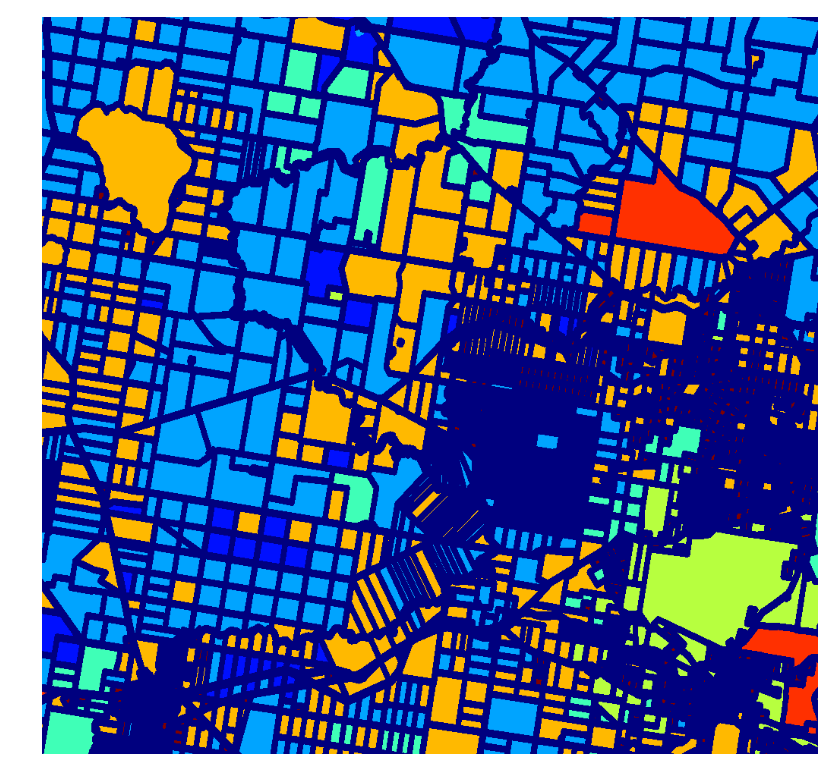

In [11]:
# label data
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(array)

In [12]:
import xgboost as xgb

In [13]:
X = full_train.ix[~np.in1d(full_train.ix[:, 'label'], [0]), 2:-1]
y = full_train.ix[~np.in1d(full_train.ix[:, 'label'], [0]), 'label']

In [14]:
param = {'max_depth':10, 'eta':0.2, 'objective':'multi:softmax', 'num_class': len(np.unique(y)), 
         'min_child_weight': 50}
num_round = 10

In [15]:
classes

{0: 'No data',
 1: 'Brassicas',
 2: 'Cereals',
 3: 'Hardwood plantation',
 4: 'Native woody cover',
 5: 'Pasture and grassland',
 6: 'Softwood Plantation',
 7: 'Unknown'}

In [16]:
dtrain = xgb.DMatrix(X, label=y-1, missing = -9999)

In [17]:
model = xgb.train(param, dtrain, num_round)

In [25]:
pred_new = model.predict(xgb.DMatrix(full_predict.ix[:, 2:], feature_names=[str(n) for n in X.columns]))

In [33]:
cls_table = pd.DataFrame(rid.generate_coordinate_columns(973, 1022), columns=['x', 'y'])
cls_table['pred_label'] = pred_new + 1
cls_map = cls_table.pivot(index='x', columns='y', values='pred_label')

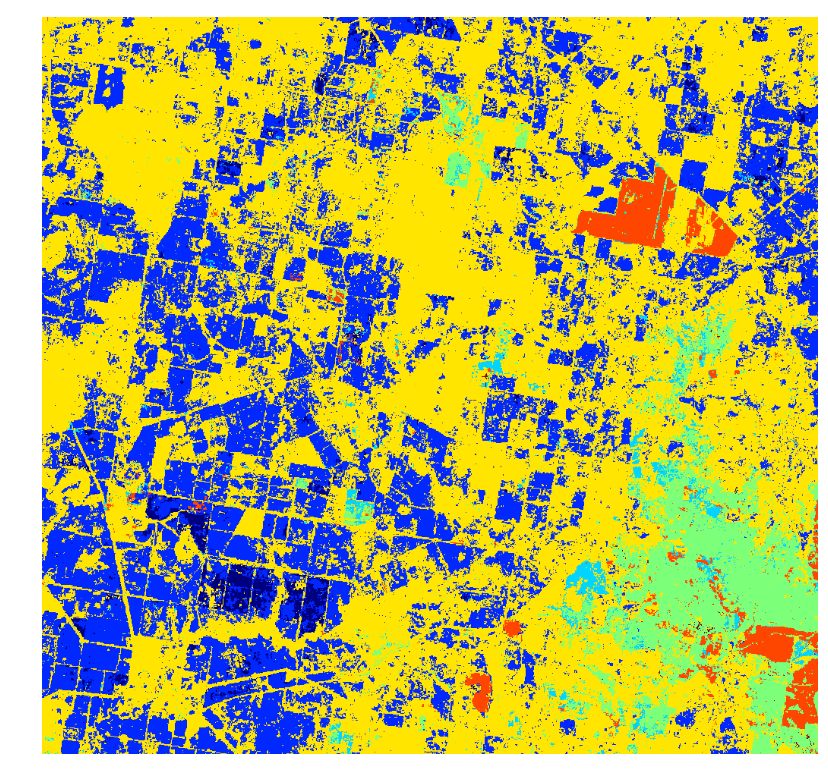

In [34]:
# prediction
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(cls_map)